In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import os
import numpy as np

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Find the latest cross-provider JSON file
json_files = glob.glob('cross_provider_test_results_*.json')
if not json_files:
    print("No cross-provider test results found!")
else:
    # Sort files by timestamp to get the latest
    json_files.sort()
    latest_file = json_files[-1]
    print(f"Loading latest file: {latest_file}")

# Load JSON data
all_data = []
for fpath in json_files:
    with open(fpath, 'r') as f:
        try:
            all_data.extend(json.load(f))
        except Exception as e:
            print(f"Error loading {fpath}: {e}")

df = pd.DataFrame(all_data)

# Filter for successful tests only
df_success = df[df['status'] == 'success'].copy()

print(f'Loaded {len(df)} total records ({len(df_success)} successful) from {len(json_files)} files')
print(f'Roundtrip types: {df_success["roundtrip_type"].unique()}')
df_success.head()

Loading latest file: cross_provider_test_results_20250716_145828.json
Loaded 279 total records (270 successful) from 4 files
Roundtrip types: ['openai_TTS → openai_STT' 'deepgram_TTS → deepgram_STT'
 'openai_TTS → deepgram_STT' 'openai_TTS → groq_STT'
 'deepgram_TTS → openai_STT' 'deepgram_TTS → groq_STT'
 'groq_TTS → groq_STT' 'groq_TTS → openai_STT' 'groq_TTS → deepgram_STT']


,timestamp,original_text,tts_provider,tts_model,tts_voice,stt_provider,stt_model,roundtrip_type,tts_time,stt_time,transcribed_text,total_time,word_error_rate,accuracy_percentage,status,error
0,2025-07-16T14:31:32.687310,"Hello, this is a test of the speech recognitio...",openai,tts-1,alloy,openai,whisper-1,openai_TTS → openai_STT,3.163089,1.841288,"Hello, this is a test of the speech recognitio...",5.004377,0.0,100.0,success,NaN
1,2025-07-16T14:31:38.197391,"Hello, this is a test of the speech recognitio...",deepgram,aura-2-athena-en,N/A,deepgram,nova-3,deepgram_TTS → deepgram_STT,1.384604,0.390284,Hello. This is a test of the speech recognitio...,1.774888,0.1,90.0,success,NaN
3,2025-07-16T14:31:41.647027,"Hello, this is a test of the speech recognitio...",openai,tts-1,alloy,deepgram,nova-3,openai_TTS → deepgram_STT,1.493540,0.532840,Hello? This is a test of the speech recognitio...,2.026380,0.1,90.0,success,NaN
4,2025-07-16T14:31:44.186805,"Hello, this is a test of the speech recognitio...",openai,tts-1,alloy,groq,whisper-large-v3-turbo,openai_TTS → groq_STT,2.704962,0.503271,"Hello, this is a test of the speech recogniti...",3.208233,0.0,100.0,success,NaN
5,2025-07-16T14:31:47.901059,"Hello, this is a test of the speech recognitio...",deepgram,aura-2-athena-en,N/A,openai,whisper-1,deepgram_TTS → openai_STT,1.077642,1.691175,"Hello, this is a test of the speech recognitio...",2.768817,0.0,100.0,success,NaN


In [75]:
# Add columns for latency per word for TTS and STT
def safe_divide(a, b):
    try:
        return a / b if b else np.nan
    except Exception:
        return np.nan

# Compute word count for each row (based on original_text for TTS, transcribed_text for STT)
df_success['original_word_count'] = df_success['original_text'].str.split().apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df_success['transcribed_word_count'] = df_success['transcribed_text'].str.split().apply(lambda x: len(x) if isinstance(x, list) else np.nan)

# Latency per word for TTS (tts_time / original_word_count)
df_success['tts_latency_per_word'] = df_success.apply(
    lambda row: safe_divide(row['tts_time'], row['original_word_count']), axis=1
)

# Latency per word for STT (stt_time / transcribed_word_count)
df_success['stt_latency_per_word'] = df_success.apply(
    lambda row: safe_divide(row['stt_time'], row['transcribed_word_count']), axis=1
)

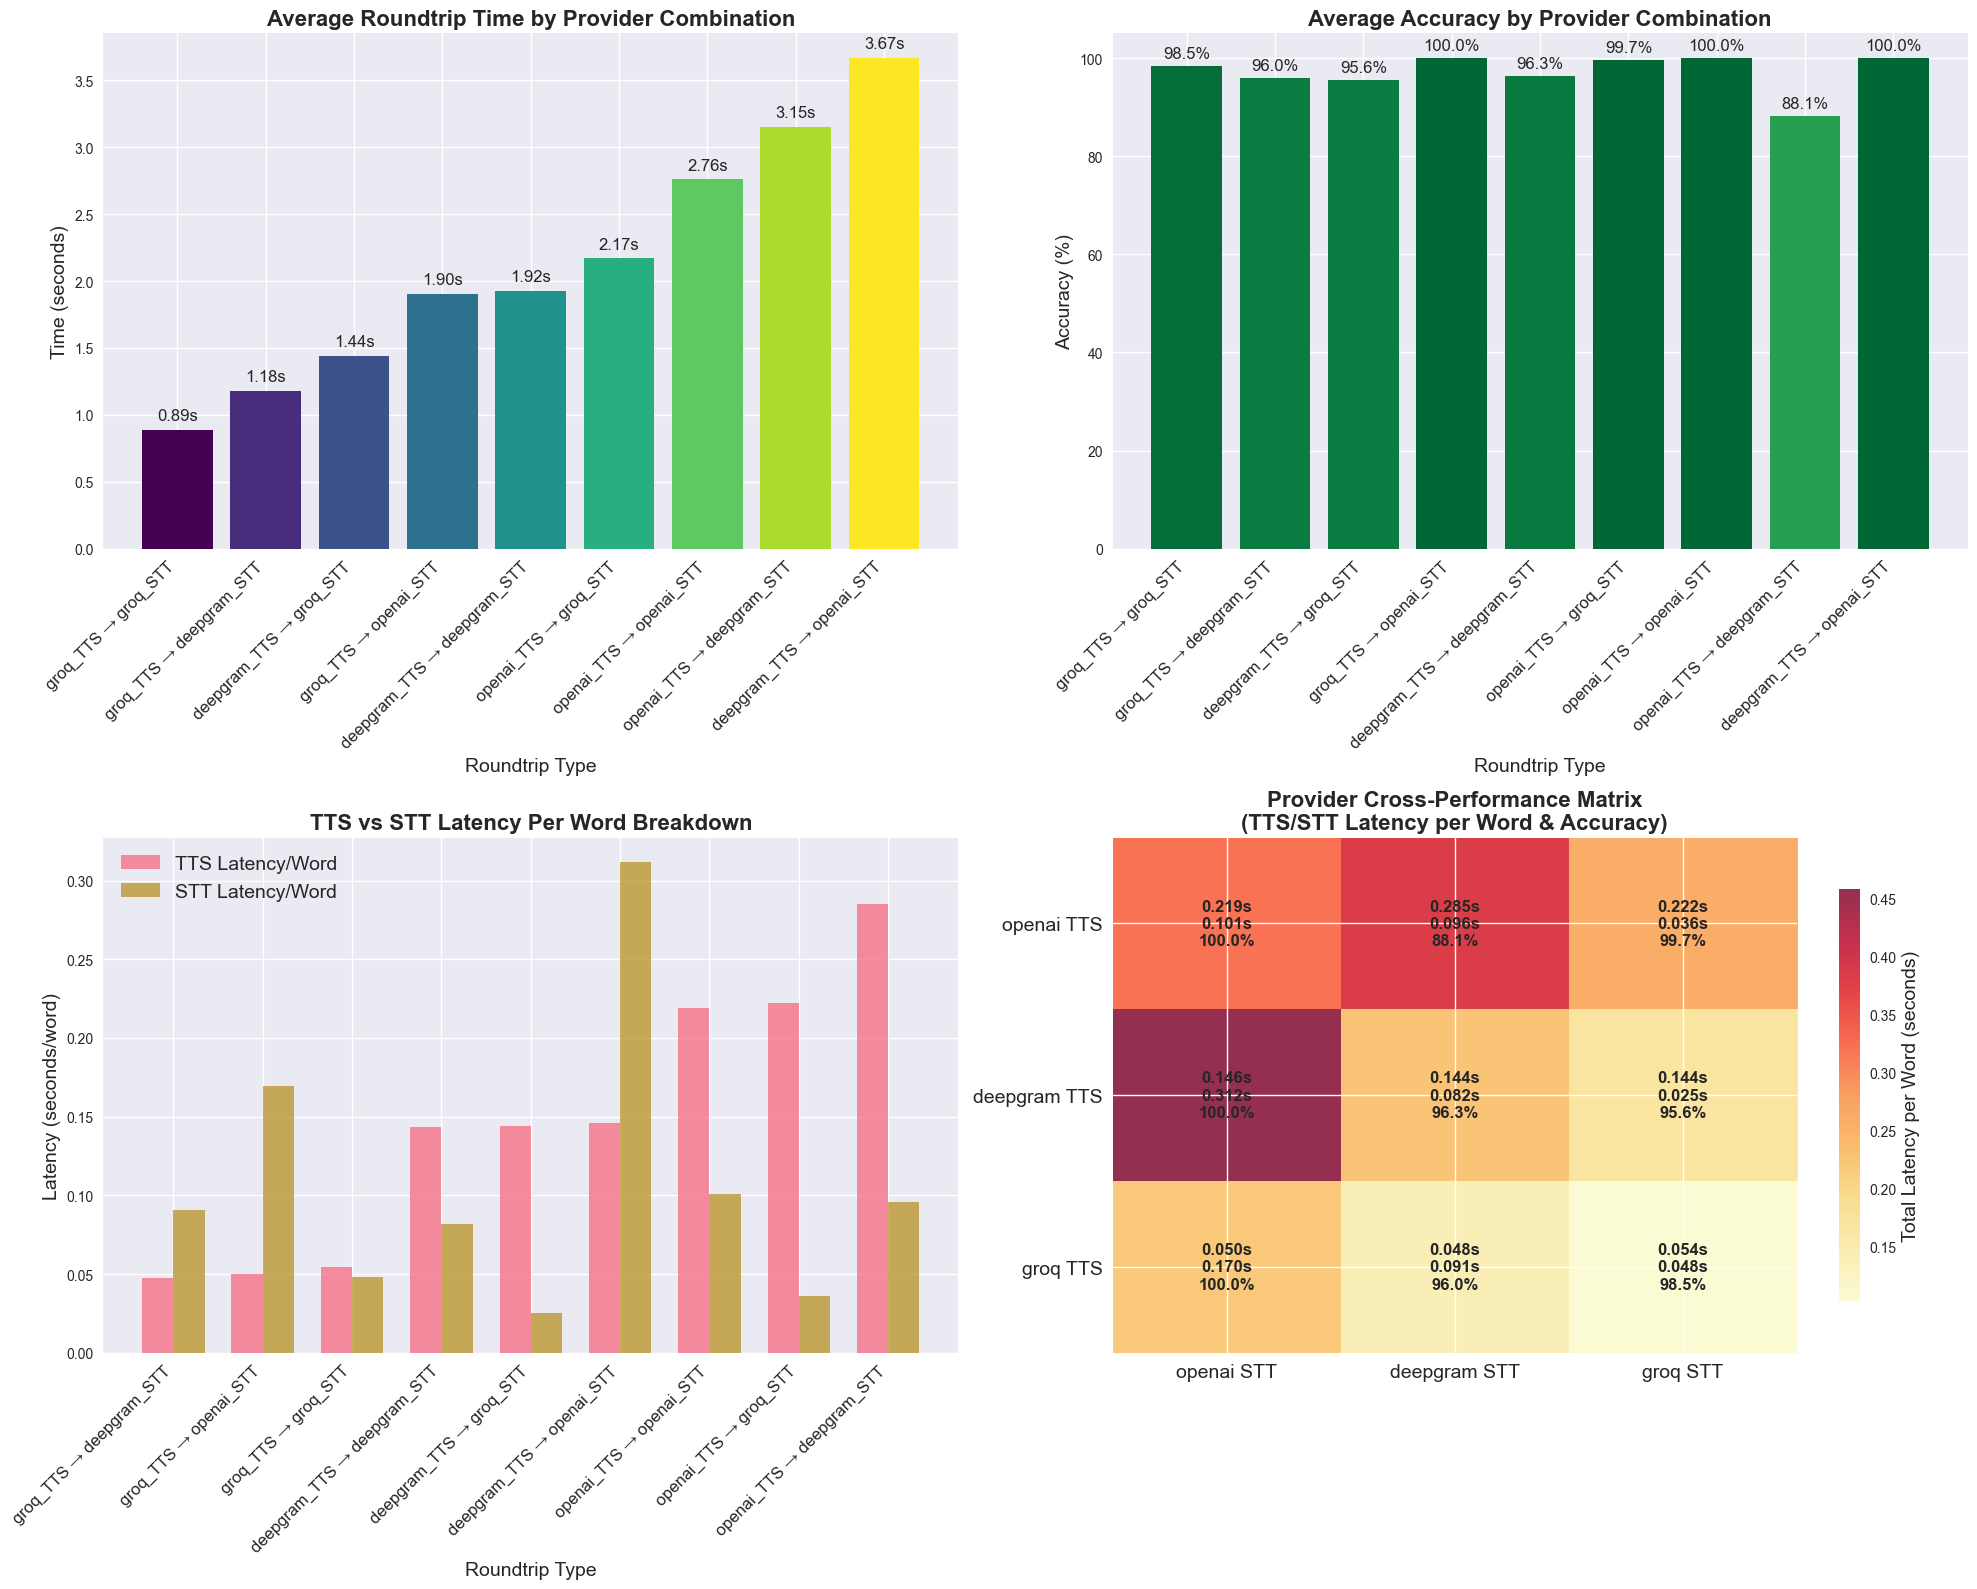

In [98]:
# Cross-Provider Roundtrip Performance Analysis (Latency Per Word)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Set font sizes
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
annot_fontsize = 12

# 1. Roundtrip Type Performance Overview (Top Left)
roundtrip_summary = df_success.groupby('roundtrip_type').agg({
    'total_time': 'mean',
    'accuracy_percentage': 'mean',
    'roundtrip_type': 'count'
}).rename(columns={'roundtrip_type': 'count'})

# Sort by total time for better visualization
roundtrip_summary = roundtrip_summary.sort_values('total_time')

bars = axes[0,0].bar(range(len(roundtrip_summary)), roundtrip_summary['total_time'], 
                     color=plt.cm.viridis(np.linspace(0, 1, len(roundtrip_summary))))
axes[0,0].set_title('Average Roundtrip Time by Provider Combination', fontsize=title_fontsize, fontweight='bold')
axes[0,0].set_ylabel('Time (seconds)', fontsize=label_fontsize)
axes[0,0].set_xlabel('Roundtrip Type', fontsize=label_fontsize)
axes[0,0].set_xticks(range(len(roundtrip_summary)))
axes[0,0].set_xticklabels(roundtrip_summary.index, rotation=45, ha='right', fontsize=tick_fontsize)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                   f'{height:.2f}s', ha='center', va='bottom', fontsize=annot_fontsize)

# 2. Accuracy by Roundtrip Type (Top Right)  
bars2 = axes[0,1].bar(range(len(roundtrip_summary)), roundtrip_summary['accuracy_percentage'],
                      color=plt.cm.RdYlGn(roundtrip_summary['accuracy_percentage']/100))
axes[0,1].set_title('Average Accuracy by Provider Combination', fontsize=title_fontsize, fontweight='bold')
axes[0,1].set_ylabel('Accuracy (%)', fontsize=label_fontsize)
axes[0,1].set_xlabel('Roundtrip Type', fontsize=label_fontsize)
axes[0,1].set_xticks(range(len(roundtrip_summary)))
axes[0,1].set_xticklabels(roundtrip_summary.index, rotation=45, ha='right', fontsize=tick_fontsize)
axes[0,1].set_ylim(0, 105)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}%', ha='center', va='bottom', fontsize=annot_fontsize)

# 3. TTS vs STT Latency Per Word Breakdown (Bottom Left)
latency_breakdown = df_success.groupby('roundtrip_type')[['tts_latency_per_word', 'stt_latency_per_word']].mean()
latency_breakdown_sorted = latency_breakdown.sort_values('tts_latency_per_word')

x = np.arange(len(latency_breakdown_sorted))
width = 0.35

axes[1,0].bar(x - width/2, latency_breakdown_sorted['tts_latency_per_word'], width, label='TTS Latency/Word', alpha=0.8)
axes[1,0].bar(x + width/2, latency_breakdown_sorted['stt_latency_per_word'], width, label='STT Latency/Word', alpha=0.8)

axes[1,0].set_title('TTS vs STT Latency Per Word Breakdown', fontsize=title_fontsize, fontweight='bold')
axes[1,0].set_ylabel('Latency (seconds/word)', fontsize=label_fontsize)
axes[1,0].set_xlabel('Roundtrip Type', fontsize=label_fontsize)
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(latency_breakdown_sorted.index, rotation=45, ha='right', fontsize=tick_fontsize)
axes[1,0].legend(fontsize=label_fontsize)

# 4. Provider-to-Provider Heatmap (Bottom Right)
# Create a matrix showing latency per word performance between providers
providers = ['openai', 'deepgram', 'groq']
heatmap_data = np.zeros((len(providers), len(providers)))
heatmap_labels = np.empty((len(providers), len(providers)), dtype=object)

for i, tts_provider in enumerate(providers):
    for j, stt_provider in enumerate(providers):
        combo_data = df_success[
            (df_success['tts_provider'] == tts_provider) & 
            (df_success['stt_provider'] == stt_provider)
        ]
        if len(combo_data) > 0:
            avg_tts_latency = combo_data['tts_latency_per_word'].mean()
            avg_stt_latency = combo_data['stt_latency_per_word'].mean()
            avg_acc = combo_data['accuracy_percentage'].mean()
            # For heatmap color, use total latency per word (sum)
            total_latency = avg_tts_latency + avg_stt_latency
            heatmap_data[i, j] = total_latency
            heatmap_labels[i, j] = f'{avg_tts_latency:.3f}s\n{avg_stt_latency:.3f}s\n{avg_acc:.1f}%'
        else:
            heatmap_data[i, j] = np.nan
            heatmap_labels[i, j] = 'N/A'

# Mask NaN values
mask = np.isnan(heatmap_data)
im = axes[1,1].imshow(heatmap_data, cmap='YlOrRd', aspect='auto', alpha=0.8)

# Add text annotations
for i in range(len(providers)):
    for j in range(len(providers)):
        if not mask[i, j]:
            axes[1,1].text(j, i, heatmap_labels[i, j], ha='center', va='center', 
                          fontsize=annot_fontsize, fontweight='bold')

axes[1,1].set_title('Provider Cross-Performance Matrix\n(TTS/STT Latency per Word & Accuracy)', fontsize=title_fontsize, fontweight='bold')
axes[1,1].set_xticks(range(len(providers)))
axes[1,1].set_yticks(range(len(providers)))
axes[1,1].set_xticklabels([f'{p} STT' for p in providers], fontsize=label_fontsize)
axes[1,1].set_yticklabels([f'{p} TTS' for p in providers], fontsize=label_fontsize)

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1,1], shrink=0.8)
cbar.set_label('Total Latency per Word (seconds)', fontsize=label_fontsize)

plt.tight_layout()
plt.savefig('audio_analysis_overall.png', dpi=500)
plt.show()

In [77]:
df_success[['tts_provider', 'tts_model']].drop_duplicates().reset_index(drop=True)


,tts_provider,tts_model
0,openai,tts-1
1,deepgram,aura-2-athena-en
2,groq,playai-tts
3,openai,gpt-4o-mini-tts
4,openai,tts-1-hd
5,deepgram,aura-2-luna-en


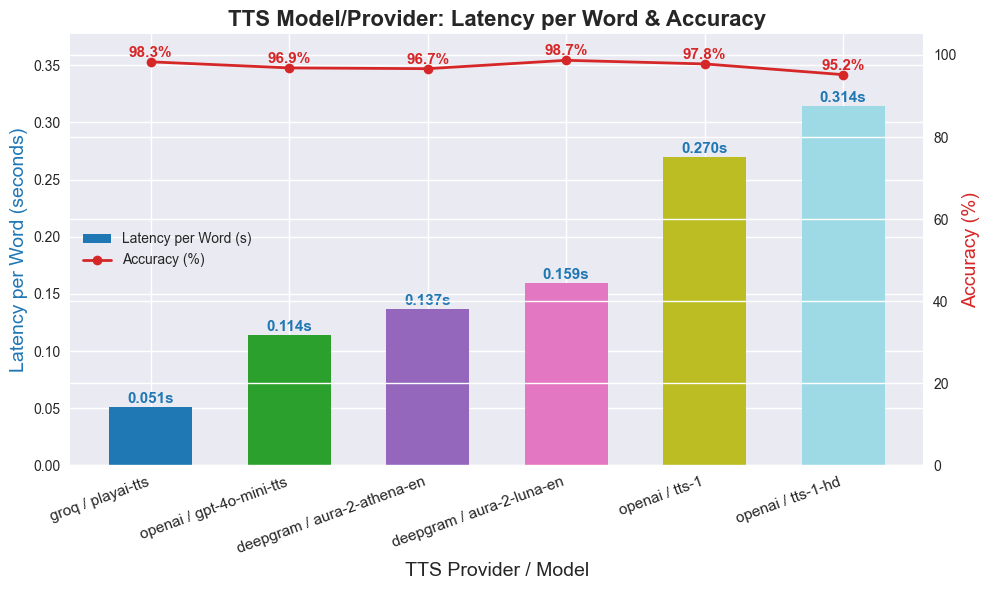

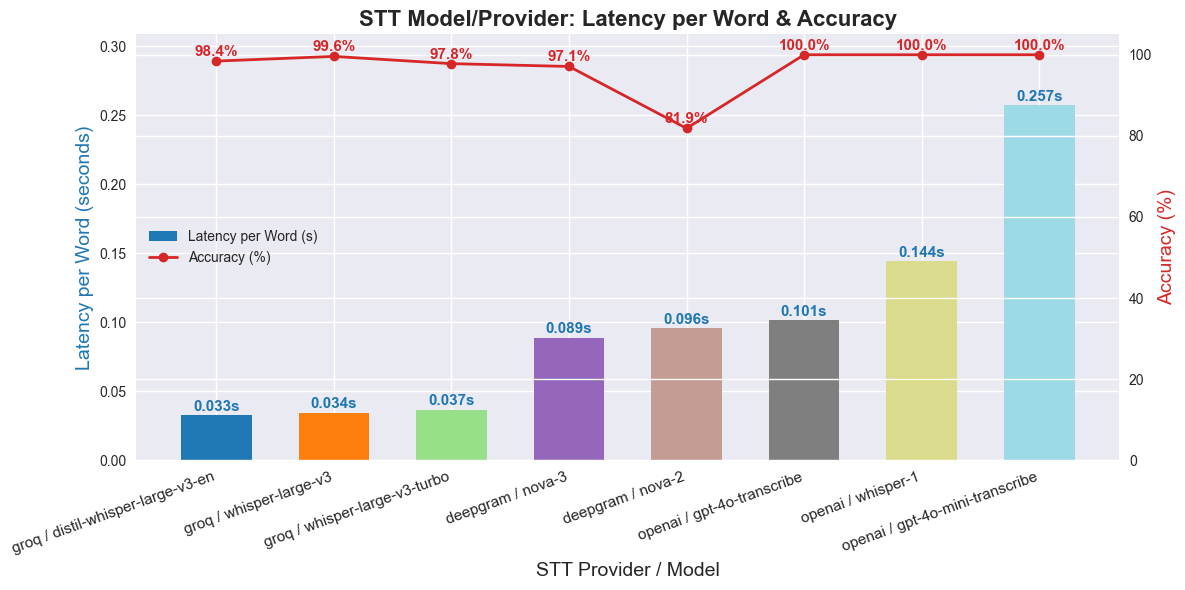

In [97]:
# Show TTS and STT breakdown for each model/provider (not just provider)
import matplotlib.pyplot as plt
import numpy as np

# Get unique provider/model combos
tts_combos = df_success[['tts_provider', 'tts_model']].drop_duplicates().reset_index(drop=True)
stt_combos = df_success[['stt_provider', 'stt_model']].drop_duplicates().reset_index(drop=True)

# TTS breakdown: average latency per word and accuracy for each provider/model
tts_stats = []
for idx, row in tts_combos.iterrows():
    tts_data = df_success[
        (df_success['tts_provider'] == row['tts_provider']) &
        (df_success['tts_model'] == row['tts_model'])
    ]
    avg_latency = tts_data['tts_latency_per_word'].mean()
    avg_acc = tts_data['accuracy_percentage'].mean()
    label = f"{row['tts_provider']} / {row['tts_model']}"
    tts_stats.append((avg_latency, avg_acc, label))

# Sort TTS by ascending latency
tts_stats_sorted = sorted(tts_stats, key=lambda x: (np.nan if x[0] is None else x[0]))

tts_latencies = [x[0] for x in tts_stats_sorted]
tts_acc = [x[1] for x in tts_stats_sorted]
tts_labels = [x[2] for x in tts_stats_sorted]

# STT breakdown: average latency per word and accuracy for each provider/model
stt_stats = []
for idx, row in stt_combos.iterrows():
    stt_data = df_success[
        (df_success['stt_provider'] == row['stt_provider']) &
        (df_success['stt_model'] == row['stt_model'])
    ]
    avg_latency = stt_data['stt_latency_per_word'].mean()
    avg_acc = stt_data['accuracy_percentage'].mean()
    label = f"{row['stt_provider']} / {row['stt_model']}"
    stt_stats.append((avg_latency, avg_acc, label))

# Sort STT by ascending latency
stt_stats_sorted = sorted(stt_stats, key=lambda x: (np.nan if x[0] is None else x[0]))

stt_latencies = [x[0] for x in stt_stats_sorted]
stt_acc = [x[1] for x in stt_stats_sorted]
stt_labels = [x[2] for x in stt_stats_sorted]

bar_width = 0.6
tts_colors = plt.cm.tab20(np.linspace(0, 1, len(tts_labels)))
stt_colors = plt.cm.tab20(np.linspace(0, 1, len(stt_labels)))

# --- Combined TTS plot: Latency (bar, left y) and Accuracy (line, right y) ---
fig, ax1 = plt.subplots(figsize=(max(10, 1.5*len(tts_labels)), 6))
x = np.arange(len(tts_labels))
bars = ax1.bar(x, tts_latencies, color=tts_colors, width=bar_width, label='Latency per Word (s)')
ax1.set_ylabel('Latency per Word (seconds)', fontsize=14, color='tab:blue')
ax1.set_xlabel('TTS Provider / Model', fontsize=14)
ax1.set_title('TTS Model/Provider: Latency per Word & Accuracy', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(tts_labels, rotation=20, ha='right', fontsize=11)
ax1.set_ylim(0, max(tts_latencies) * 1.2 if tts_latencies else 1)
for i, v in enumerate(tts_latencies):
    if not np.isnan(v):
        ax1.text(i, v + 0.001, f"{v:.3f}s", ha='center', va='bottom', fontsize=11, fontweight='bold', rotation=0, color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x, tts_acc, color='tab:red', marker='o', linewidth=2, label='Accuracy (%)')
for i, v in enumerate(tts_acc):
    if not np.isnan(v):
        ax2.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold', rotation=0, color='tab:red')
ax2.set_ylabel('Accuracy (%)', fontsize=14, color='tab:red')
ax2.set_ylim(0, 105)

# Legends
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='center left')

plt.tight_layout()
plt.savefig('tts_analysis.png', dpi=300)
plt.show()

# --- Combined STT plot: Latency (bar, left y) and Accuracy (line, right y) ---
fig, ax1 = plt.subplots(figsize=(max(10, 1.5*len(stt_labels)), 6))
x = np.arange(len(stt_labels))
bars = ax1.bar(x, stt_latencies, color=stt_colors, width=bar_width, label='Latency per Word (s)')
ax1.set_ylabel('Latency per Word (seconds)', fontsize=14, color='tab:blue')
ax1.set_xlabel('STT Provider / Model', fontsize=14)
ax1.set_title('STT Model/Provider: Latency per Word & Accuracy', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(stt_labels, rotation=20, ha='right', fontsize=11)
ax1.set_ylim(0, max(stt_latencies) * 1.2 if stt_latencies else 1)
for i, v in enumerate(stt_latencies):
    if not np.isnan(v):
        ax1.text(i, v + 0.001, f"{v:.3f}s", ha='center', va='bottom', fontsize=11, fontweight='bold', rotation=0, color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(x, stt_acc, color='tab:red', marker='o', linewidth=2, label='Accuracy (%)')
for i, v in enumerate(stt_acc):
    if not np.isnan(v):
        ax2.text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold', rotation=0, color='tab:red')
ax2.set_ylabel('Accuracy (%)', fontsize=14, color='tab:red')
ax2.set_ylim(0, 105)

# Legends
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='center left')

plt.tight_layout()
plt.savefig('stt_analysis.png', dpi=300)
plt.show()
